In [1]:
import sys
sys.path.append("..")

import h5py
import numpy as np
from tqdm import tqdm
from pathlib import Path
from scipy.stats import norm
from utils.plot_utils import *
import matplotlib.pyplot as plt
from astropy import units, constants
from scipy.interpolate import griddata

In [2]:
from julia import Main

In [3]:
Main.eval("Threads.nthreads()")

10

## Velocity Broadening
The beamsource can be modelled as an extended source, spawning molecules in a 2D gaussian distribution with width $\sigma = 4.83 mm$ at 1 cm from the cell opening.  
From Oskari's beamsource characterization report the forward velocity is 184 m/s $\pm$ 16.8 m/s, width a transverse velocity $\sigma_\perp = 93/2\sqrt{2}\log{2}$ m/s.  

The Doppler shift in frequency is given by $f = f_0 \left(1+v/c\right)$, where $f_0$ is the rest frequency.

In [4]:
@units.quantity_input
def doppler_shift(v: units.m/units.s, frequency: units.Hz):
    return (frequency*(1+v/constants.c)).to(units.Hz)

In [5]:
Γ = (1/(100*units.ns)).to(units.Hz)
vp = 1*units.m/units.s
ω = (2*np.pi*constants.c/(271*units.nm)).to(units.Hz)

In [6]:
v_to_Γ = (doppler_shift(vp,ω) - ω)/Γ
print(f'1 m/s transverse velocity results in a frequency shift of {v_to_Γ:.2f} Γ')

1 m/s transverse velocity results in a frequency shift of 2.32 Γ


## Running in Julia

In [7]:
Main.eval("""using Waveforms""")
Main.eval("""using DifferentialEquations""")
Main.eval("""using BenchmarkTools""")
Main.eval("""
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())
""")

<PyCall.jlwrap Logging.ConsoleLogger(Base.TTY(Base.Libc.WindowsRawSocket(0x00000000000007dc) open, 0 bytes waiting), Info, Logging.default_metafmt, true, 0, Dict{Any,Int64}())>

In [8]:
Main.eval("""
function square_wave(t::Float64, frequency::Float64, phase::Float64)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

In [9]:
# reading from file
with open('../ode_fun_mu1.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [10]:
print(ode_fun[:323])


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω = p[1]
		Ωᶜ = conj(Ω)
		νp = p[2]
		Ω1 = p[3]
		Ω1ᶜ = conj(Ω1)
		νp1 = p[4]
		Δ = p[5]
		Plx = square_wave(t, νp, 3.141592653589793)
		Plz = square_wave(t, νp, 0.0)    
		Pm1y = square_wave(t, νp1, 1.5707963267948966)
		Pm1z = square_wave(t, νp1, 4.71238898038469)



In [11]:
Main.eval(ode_fun)

<PyCall.jlwrap Lindblad_rhs!>

Loading initial population at 7 K

In [12]:
data_dir = Path('../stored_data')

fnames = ['rho_ini']

for fname in fnames:
    if fname == 'rho_ini':
        ρ_ini = np.load(data_dir / (fname + '.npy'))
    else:
        globals()[fname] = np.load(data_dir / (fname + '.npy'))

In [13]:
de_main = -0.39444661382277774 # main dipole transition moment
Γ = 1/(100e-9)
Ω =  1*Γ*abs(de_main)
ωp = Γ
νp = ωp/(2*np.pi)
νp1 = νp
Ω1 = Γ
Δ = 0

Main.Ω = Ω
Main.νp = νp
Main.Ω1 = Ω1
Main.νp1 = νp1
Main.Δ = Δ
Main.Γ = Γ

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("p = [Ω, νp, Ω1, νp1, Δ]")

array([ 3944466.13822778,  1591549.43091895, 10000000.        ,
        1591549.43091895,        0.        ])

In [14]:
Main.eval("""
tmp = zeros(ComplexF64,39,39)
Lindblad_rhs!(tmp, ρ_ini, p, 1e-6)
@btime Lindblad_rhs!(tmp, ρ_ini, p, 1e-6)
tmp = 0
""")

0

With the position dependent light intensity the execution time is 5.233 $\mu$seconds

## Single pass first
Setup a callback to stop solver when it reaches a certain position, in this case the end of the multi pass

In [15]:
Main.vz = 184

In [16]:
Main.eval("""
condition(u,t,integrator) = vz*t > 0.05
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition, affect!)
""")

<PyCall.jlwrap DiscreteCallback{typeof(condition),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, Bool[1, 1])>

Ω1 = 0.5Γ -> 6.71 ratio J0
Ω1 = 1.0Γ -> 6.74 ratio J0
Ω1 = 1.5Γ -> 7.19 ratio J0
Ω1 = 2.0Γ -> 7.39 ratio J0
Ω1 = 2.5Γ -> 7.45 ratio J0
Ω1 = 3.0Γ -> 7.45 ratio J0
Ω1 = 3.5Γ -> 7.41 ratio J0
Ω1 = 4.0Γ -> 7.26 ratio J0
Ω1 = 4.5Γ -> 7.24 ratio J0


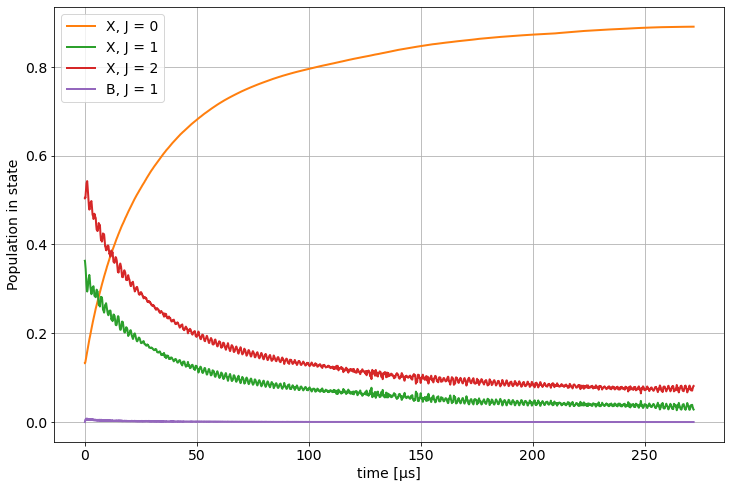

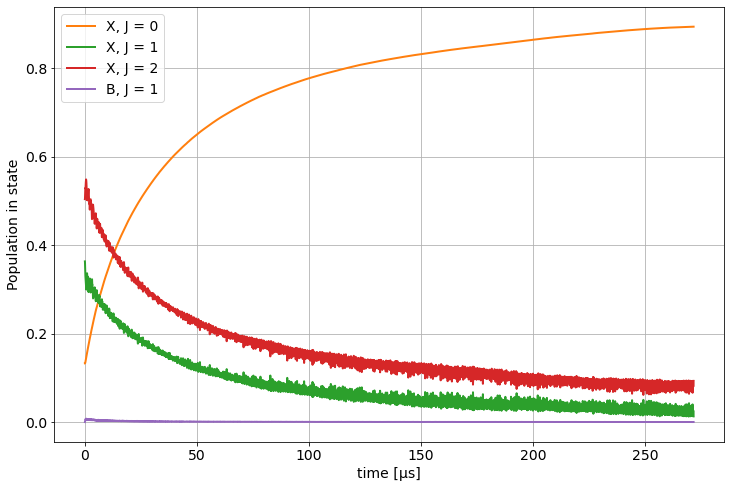

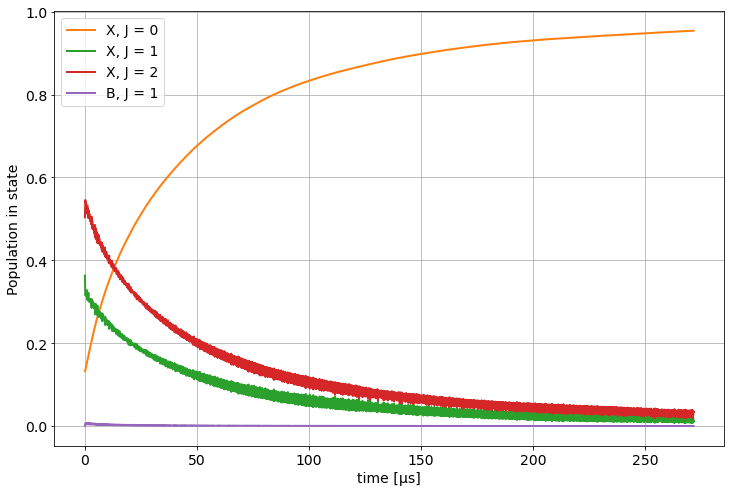

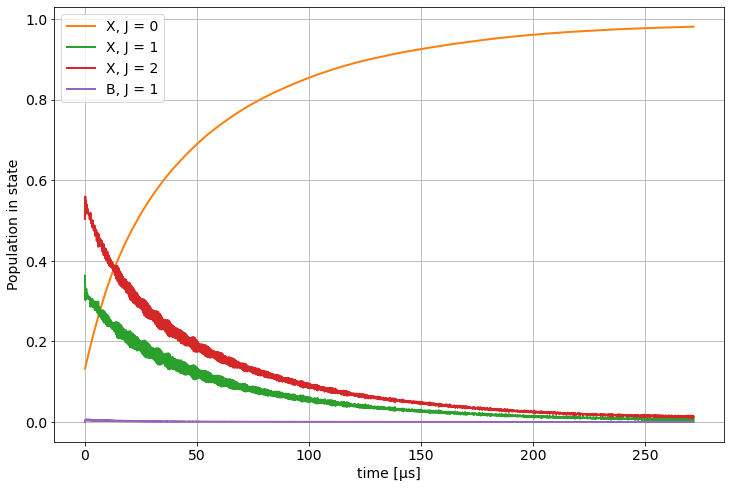

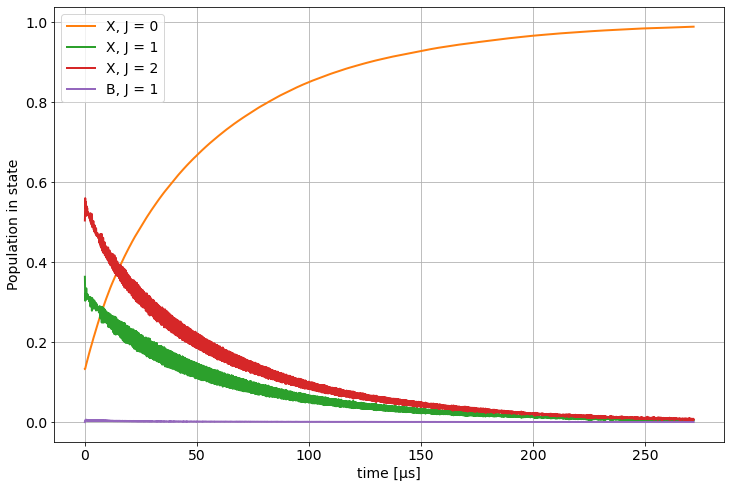

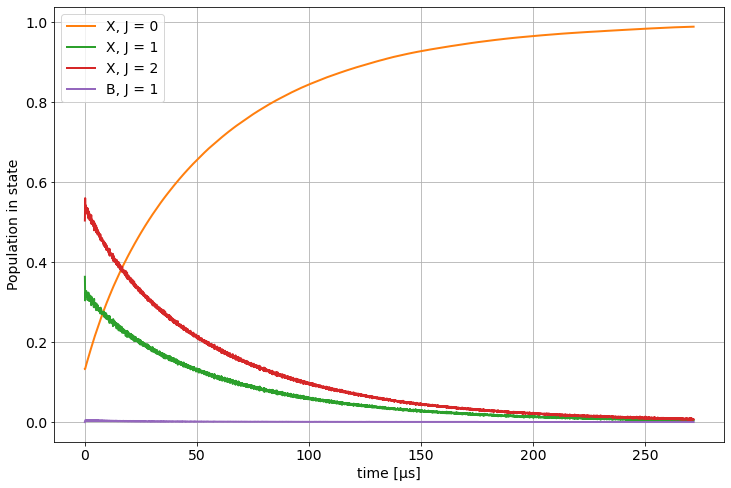

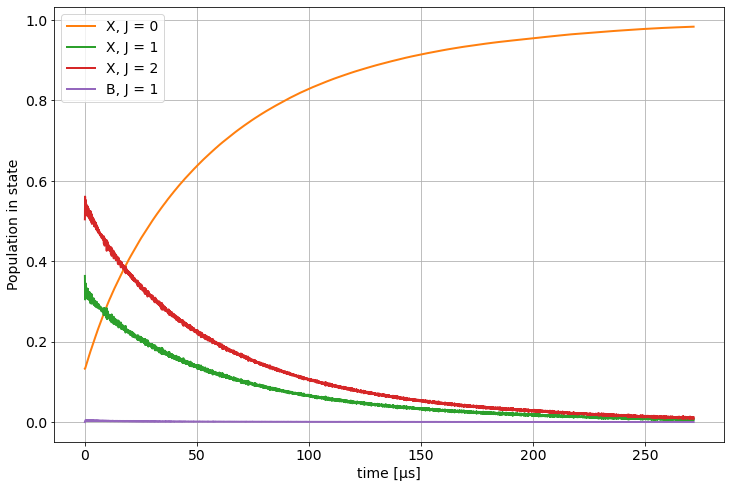

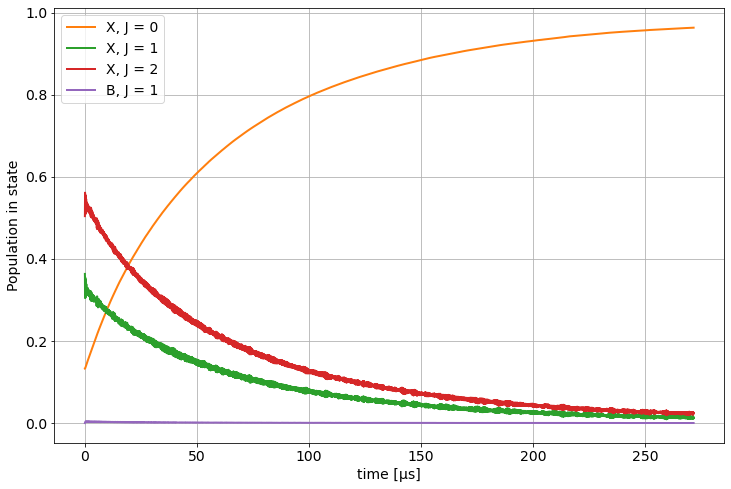

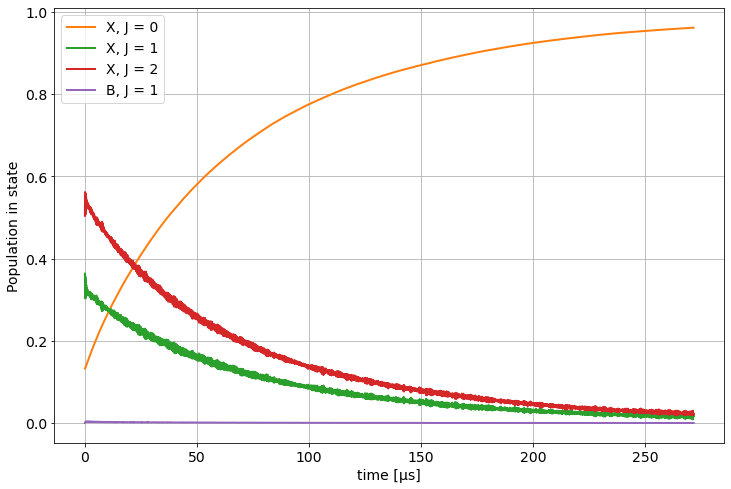

In [17]:
for Ω1 in Γ*np.arange(0.5,5,0.5):
    Main.Ω1 = Ω1
    Main.eval("p = [Ω, νp, Ω1, νp1, Δ]")
    Main.eval("""
    tspan = (0.0f0, 500e-6)
    prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
    tmp = 0
    """)

    Main.eval("""
    @time sol = solve(prob,Tsit5(),callback=cb)
    tmp = 0
    """)

    ut = np.array(Main.eval("sol[:]")).T
    pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
    t_array = Main.eval("""sol.t""").copy()

    t_array

    #Plot populations in different J
    P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
    P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
    P0 = np.sum(pop_results[:4], axis = 0)
    P1 = np.sum(pop_results[4:16,:], axis = 0)
    P2 = np.sum(pop_results[16:36,:], axis = 0)
    PB1 = np.sum(pop_results[36:,:], axis = 0)

    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(t_array*1e6, P0, label = 'X, J = 0', lw = 2, color = 'C1')
    ax.plot(t_array*1e6, P1, label = 'X, J = 1', lw = 2, color = 'C2')
    ax.plot(t_array*1e6, P2, label = 'X, J = 2', lw = 2, color = 'C3')
    ax.plot(t_array*1e6, PB1, label = 'B, J = 1', lw = 2, color = 'C4')

    ax.legend(fontsize = 14)
    ax.set_xlabel('time [μs]', fontsize = 14)
    ax.set_ylabel("Population in state", fontsize = 14)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True)

    print(f"Ω1 = {Ω1/Γ:.1f}Γ -> {(P0[-1]/np.diag(ρ_ini)[:4].sum()).real:.2f} ratio J0")

## Defining a parameter sweep of Ω and Ω1

In [19]:
Main.eval("Omegas = (Ω)*(0.1:0.1:6)")
Main.eval("Omegas1 = (Γ)*(0.1:0.1:6)")

params = np.empty([len(Main.Omegas)*len(Main.Omegas1),2])
params[:,0] = np.repeat(Main.Omegas, len(Main.Omegas1))
params[:,1] = np.tile(Main.Omegas1, len(Main.Omegas))
Main.params = params

In [20]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.616037013755e9, 1.616037013755e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x00000000000007dc) open, 0 bytes waiting), 0, 0, 0)>

In [21]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [22]:
# defining the function that changes the ODE parameters for each iteration
# p = [Ω, νp, Ω1, νp1, Δ]
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; νp; params[i,2]; params[i,1]; νp1; Δ])
end
""")

<PyCall.jlwrap prob_func>

In [23]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [24]:
# making sure multiple threads are enabled
Main.eval("Threads.nthreads()")

10

In [ ]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4, callback = cb)
sim.elapsedTime
""")

In [ ]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [ ]:
# putting the results into a single numpy array
results_array = np.zeros([len(ens_u),3+39])

for idx, ((Ω_factor, Ω1_factor), ut_ens) in tqdm(enumerate(zip(Main.params,ens_u)), total = len(ens_u)):
    results_array[idx,:] = [Ω_factor, Ω1_factor, Main.Δ] + list(ut_ens)

In [ ]:
fname = 'scan_microwave_and_laser_power.npy'
np.save(fname, results_array)

In [ ]:
fname = 'scan_microwave_and_laser_power.npy'
results_array = np.load(fname)

In [ ]:
# for making Ω slices I round Ω_factor to two digits to preven any floating point issues
# keep in mind when the desired spacing is less than two digits to remove rounding or 
# increase the digits
results_array_J0 = np.zeros([len(results_array),7])
for idx, (Ω_factor, Ω1_factor, vy_factor, y0_factor, *pops) in tqdm(enumerate(results_array), total = len(results_array)):
    results_array_J0[idx,:] = [round(Ω_factor/Γ/abs(de_main),2), Ω1_factor, Δ_factor/Γ, np.sum(pops[:4])]

In [ ]:
P0_ini = np.diag(ρ_ini[:4,:4]).sum().real

for Ω_factor in np.unique(results_array_J0[:,0]):
    for Ω1_factor in np.unique(results_array_J0[:,1]):
        m = results_array_J0[:,0] == Ω_factor
        m1 = results_array_J0[:,1] == Ω1_factor
        m = m & m1
        mean_population = np.mean(results_array_J0[m][:,-1])/P0_ini
        mean_err_population = np.std(results_array_J0[m][:,-1]/P0_ini)/np.sqrt(trajectories)
        print(f'Ω : {Ω_factor:.1f}; Ω1 : {Ω1_factor/Γ/abs(de_main):.1f} MHz -> ratio = {mean_population:.3f} +/- {mean_err_population:.3f}')

In [ ]:
P1_ini = np.diag(ρ_ini[4:16,4:16]).sum().real

for Ω_factor in np.unique(results_array[:,0]):
    for Ω1_factor in np.unique(results_array[:,1]):
        m = results_array[:,0] == Ω_factor
        m1 = results_array[:,1] == Ω1_factor
        m = m & m1
        d = results_array[:,-39:][m]
        mean_population = np.mean(d[:,4:16].sum(axis = 1))/P1_ini
        mean_err_population = np.std(d[:,4:16].sum(axis = 1)/P1_ini)/np.sqrt(trajectories)
        print(f'Ω : {round(Ω_factor/Γ/abs(de_main),2):.1f}; Ω1 : {Ω1_factor/1e6:.1f} MHz -> ratio = {mean_population:.3f} +/- {mean_err_population:.3f}')

In [ ]:
for Ω_factor in np.unique(results_array_J0[:,0]):
    m = results_array_J0[:,0] == Ω_factor
    dat = results_array_J0[m,-1]/P0_ini
    fig, ax = plt.subplots(figsize = (8,5))
    ax.hist(dat, bins = 50)
    ax.set_xlabel(f'population ratio $J_0$ rc on / rc off')
    set_fontsize(ax, 14)
    
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    
    text = f"{np.mean(dat):.3f}$\pm${np.std(dat)/np.sqrt(len(dat)):.3f} pop ratio in $J=0$"
    ax.text(0.05, 0.75, text, transform = ax.transAxes, fontsize = 15, bbox = props,
            va = 'bottom', ha = 'left')
    
    text = f"Ω = {Ω_factor:.1f} Γ"
    ax.text(0.05, 0.95, text, transform = ax.transAxes, fontsize = 15, bbox = props,
            va = 'top', ha = 'left')

In [ ]:
bins = np.linspace(1,3.5,51)

fig, ax = plt.subplots(figsize = (8,5))

for Ω_factor in np.unique(results_array_J0[:,0]):
    m = results_array_J0[:,0] == Ω_factor
    dat = results_array_J0[m][:,-1]/P0_ini
    ax.hist(dat, bins = bins, label = f'Ω : {Ω_factor:.0f} Γ', alpha = 0.7, density = True)
    ax.set_xlabel(f'population ratio $J_0$ rc on / rc off')
    set_fontsize(ax, 14)
ax.legend(fontsize = 14)

In [ ]:
r = np.diag(ρ_ini)
print("Populations (ignoring population in J=1 and levels above J=2)")
print(f"pop in J=2 : {np.real(r[16:36].sum()/(r[:4].sum() + r[16:36].sum())):.2f}")
print(f"pop in J=0 : {np.real(r[:4].sum()/(r[:4].sum() + r[16:36].sum())):.2f}")

In [ ]:
resultsJ2 = []
resultsJ0 = []

for Ω_factor in np.unique(results_array[:,0]):
    m = results_array[:,0] == Ω_factor
    pop = results_array[m][:,-39:]
    resultsJ2.append(pop[:,16:36].sum()/(pop[:,:4].sum() + pop[:,16:36].sum()))
    resultsJ0.append(pop[:,:4].sum()/(pop[:,:4].sum() + pop[:,16:36].sum()))
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.unique(results_array[:,0])/Γ/abs(de_main), resultsJ0, ls = '-', marker = '.', ms = 14, label = 'J = 0')
ax.plot(np.unique(results_array[:,0])/Γ/abs(de_main), resultsJ2, ls = '-', marker = '.', ms = 14, label = 'J = 2')

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('population')
ax.set_title('Normalized for J=0,2')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)